## 손실함수 
- (앞은 다 아는 내용이라 넘어감 여기서도 MAE, cross_entropy_error 두개 흝어보고만 지나가면 됨)

In [2]:
import numpy as np
y2 = np.array([0.1, 0.05, 0.7, 0.05, 0.05, 0, 0, 0, 0, 0.05]) # 2일 확률이 가장 높음
y0 = np.array([0.5, 0.3, 0.1, 0.05, 0.05, 0, 0, 0, 0, 0]) # 0일 확률이 가장 높음
# 넣는건 꼭 array로!
answer = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0] # 정답 2

def mean_squared_error(y, t):
    return 0.5 * np.sum((y - t)**2)

In [3]:
print(mean_squared_error(y2, answer)) # 더 작으므로 정답에 가까움
print(mean_squared_error(y0, answer))

0.055000000000000014
0.5774999999999999


In [4]:
def cross_entropy_error(y, t):
    delta = 1e-10 # np.log에 0이 입력되었을때 -inf가 되기 때문에 그걸 방지하기 위해
    # 엄청나게 작은 수를 더해줌
    return -np.sum(t * np.log(y + delta)) # np.log = 자연로그

In [5]:
print(cross_entropy_error(y2, answer)) # 더 작으므로 정답에 가까움
print(cross_entropy_error(y0, answer))

0.3566749437958753
2.302585091994046


## 미니배치
- 손실함수 값은 모든 데이터를 대상으로 구해야 함 (100개면 100개, 60000개면 60000개...)
- 데이터가 수백만개가 되면 너무 비효율적임 --> 근사치를 이용
- 데이터를 100개 정도만 뽑아서 100개의 손실함수를 구하고 그것을 평균냄

In [6]:
import tensorflow as tf

mnist = tf.keras.datasets.mnist
(x_train, t_train), (x_test, t_test) = mnist.load_data() # 정규화와 one_hot_encoding 수행

t_train_one_hot = np.zeros((t_train.size, t_train.max()+1)) # 배열 원핫인코딩 코드
t_train_one_hot[np.arange(t_train.size),t_train] = 1

t_test_one_hot = np.zeros((t_test.size, t_test.max()+1)) # 배열 원핫인코딩 코드
t_test_one_hot[np.arange(t_test.size),t_test] = 1

# x_train = np.array(list(map(lambda n : n / 255, x_train))) # 정규화 코드
# x_test = np.array(list(map(lambda n : n / 255, x_test))) # 정규화 코드

x_train = np.array(list(map(lambda n : n.reshape(784, ), x_train))) # flatten 코드
x_test = np.array(list(map(lambda n : n.reshape(784, ), x_test))) # flatten 코드

print(x_train.shape, t_train_one_hot.shape)

(60000, 784) (60000, 10)


In [7]:
t_train = t_train_one_hot.copy()
t_test = t_test_one_hot.copy()

train_size = x_train.shape[0]
batch_size = 10
batch_mask = np.random.choice(train_size, batch_size)
x_batch = x_train[batch_mask]
t_batch = t_train[batch_mask]

# 예시
print(np.random.choice(60000, 10))

[ 6488  3724 37842 18262 32779 19481 34831 17825 56672 15064]


In [8]:
def cross_entropy_error2(y, t):
    if y.dim == 1:
        t = t.reshape(1, t.size) # size는 배열안이 몇 차원이든 요소의 개수를 전부 출력함
        y = y.reshape(1, y.size) # mnist의 경우에는 784 * 60000?
        # 1차원이 이 안에 들어가면 2차원이 됨, 놀라운 발견!
        # ex) [0, 1, 2] --> [[0, 1, 2]]
        
    batch_size = y.shape[0] # 배치사이즈가 100이면 이미지가 100개라는 뜻
    # [100, 100, 100, 100] <-- 0번째니 100이 됨
    return -np.sum(t * np.log(y + 1e-10)) / batch_size # batch_size로 나누는 것은 정규화를 위한 것

In [9]:
# 근데 이 함수는 굳이 안써도 될거같음
def cross_entropy_error3(y, t): # 정답 레이블이 원핫 인코딩으로 주어지지 않았을 경우
    if y.dim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-10)) / batch_size

# np.arange를 사용하면 배치사이즈만큼의 ([0 ~ 99] <-- 이런 어레이가 만들어짐)
# 여기에 t는 정답 레이블 [2, 7, 0...]
# 따라서 y[0, 2], y[1, 7]... <-- 2차원 어레이 y의 0번째 2, y의 1번째 7...

## 정확도 대신 손실함수 (loss function)을 사용하는 이유
- 용어: 매개변수 = 가중치와 편향
- 정확도를 기준으로 사용하면 매개변수 변경으로 정확도가 개선된다 해도 34%, 35% 이런 불연속적인 값으로 변함
- 그 이유는 신경망 학습에서 매개변수의 미분 값을 단서로 매개변수를 서서히 갱신시키기 때문
- 기울기가 음수면 매개변수를 양의 방향으로 변화시켜 손실함수를 줄임
- 반대로 기울기가 양수면 매개변수를 음의 방향으로 변화시켜 손실함수를 줄임
- 미분값이 0이 되게 하는 것이 목표, 기울기가 0이 되면 매개변수 갱신이 멈춤
- 하지만 손실함수를 사용하면 0.92543, 0.93432... 이렇게 연속적으로 변화시킬 수 있음
- 계단 함수와 시그모이드 함수를 생각하면 편함

## 수치미분을 파이썬으로 구현

In [10]:
import numpy as np
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D # 3차원 그래프 그리기 위해 임포트

In [11]:
# 미분값 구하기 함수
def numerical_diff(f, x):
    h = 1e-4 # 0.0001
    return (f(x + h) - f(x - h)) / (2 * h)

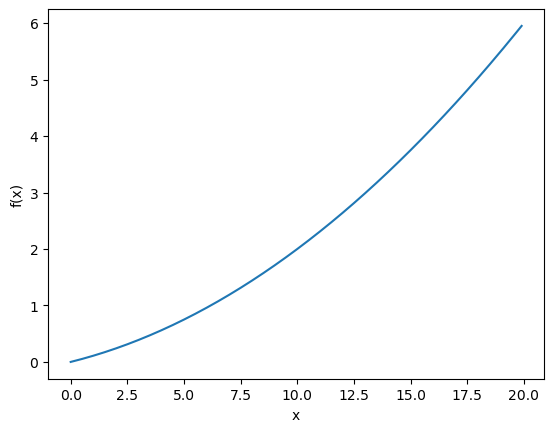

In [12]:
# 테스트용 방정식
# y = 0.01x^2 + 0.1x

def function_1(x): # 위 식을 함수화
    return 0.01*x**2 + 0.1*x

x = np.arange(0.0, 20.0, 0.1) # 0 ~ 20까지 단위는 0.1
y = function_1(x)
plt.xlabel("x")
plt.ylabel("f(x)")
plt.plot(x, y)
plt.show()

In [13]:
print(numerical_diff(function_1, 5)) # 5에서의 미분값
print(numerical_diff(function_1, 10)) # 10에서의 미분값

0.1999999999990898
0.2999999999986347


In [14]:
def function_2(x, y):
    return x**2 + y**2 # 또는 return np.sum(x**2)

def function_2_1(x): # <-- 이건 안됨, 왤까....?
    return np.sum(x**2)

2


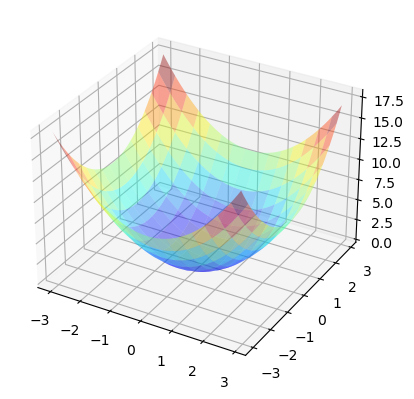

In [52]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# x = [0, 0, 1, 1]
# y = [0, 1, 0, 1]
# z = [-1, -1, -1, -1]

X = np.arange(-3.0, 3.0, 0.1)
Y = np.arange(-3.0, 3.0, 0.1)
X, Y = np.meshgrid(X, Y) # <-- 이게 없어서 그랬음
Z1 = np.array([X, Y])
Z = function_2(Z1)

print(Z.ndim) # <-- Z 차원 확인 필수! 2차원이어야함

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# ax.plot(x, y, z, linestyle="none", marker="o", mfc="none", markeredgecolor="red")
ax.plot_surface(X, Y, Z, rstride=4, cstride=4, alpha=0.4, cmap=cm.jet)

plt.show()

In [57]:
# 편미분 문제
def function_tmp1(x):
    return x * x + 4.0 ** 2.0 # x가 3, y 가 4일때 "x0 ** 2 + x1 ** 2" <-- 이 식을 x에서의 편미분을 하면? ==> 답이 return 값임

print(numerical_diff(function_tmp1, 3.0))

def function_tmp2(y):
    return 3.0 ** 2.0 + y * y # x가 3, y 가 4일때 "x0 ** 2 + x1 ** 2" <-- 이 식을 y에서의 편미분을 하면? ==> 답이 return 값임

print(numerical_diff(function_tmp2, 4.0))

6.00000000000378
7.999999999999119


In [61]:
# x, y의 편미분을 동시에 계산하기
# (∂f/∂x, ∂f/∂y)를 계산한다고 했을 때, 쟤((∂f/∂x, ∂f/∂y))처럼 모든 변수의 편미분을 벡터로 정리한 것을 기울기라고 함
# 기울기를 함수로 구현하면 다음과 같음

def numerical_gradient(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x) # x와 형상이 같은 배열을 생성
    
    for idx in range(x.size):
        tmp_val = x[idx]
        
        # f(x+h) 계산
        x[idx] = tmp_val + h
        fxh1 = f(x)
        
        # f(x-h)
        x[idx] = tmp_val - h
        fxh2 = f(x)
        
        grad[idx] = (fxh1 - fxh2) / (2 * h)
        x[idx] = tmp_val # 값 복원
        
    return grad

In [64]:
print(numerical_gradient(function_2, np.array([3.0, 4.0]))) # <-- 셋 다 array임
print(numerical_gradient(function_2, np.array([0.0, 2.0])))
print(numerical_gradient(function_2, np.array([3.0, 0.0])))

[6. 8.]
[0. 4.]
[6. 0.]


In [ ]:
# 아래 그림은 위의 무지개색 plot을 생각해보면 바로 알 수 있음
# 기울기는 각 지점에서 낮아지는 방향을 가리킵니다.
# 정확히 말하면
# ★★기울기가 가리키는 쪽은 각 장소에서 함수의 출력 값을 가장 크게 줄이는 방향★★
# ↑ 이건... 기울기가그 점 내에서 낮아지는 부분을 접선 방향으로 가리키고 있으니까
# 당연한 얘기같음!

<img src = "image/9.png">

## 경사법 (경사 하강법)

- 경사하강법은 각 지점에서 함수의 값을 낮추는 방안을 제시하는 지표가 기울기라는 것
- 그러나 기울기가 가리키는 곳에 정말 함수의 최솟값이 있는지
- 즉 그쪽이 정말로 나아갈 방향인지는 보장할 수 없음
- 실제로 복잡한 함수에서는 기울기가 가리키는 방향에 최솟값이 없는 경우가 대부분

<img src = 'image/10.png'>

In [99]:
def gradient_descent(f, init_x, lr = 0.01, step_num = 100):
    x = init_x
    test_list1 = []
    test_list2 = []
    for i in range(step_num):
        grad = numerical_gradient(f, x)
        x -= lr * grad
        test_list1.append(x[0])
        test_list2.append(x[1])
    plt.scatter(test_list1, test_list2)
    plt.show()
    return x
# f는 최적화하려는 함수, init_x는 초깃값, lr은 learning rate, step_num은 경사법에 따른 반복 횟수
# 이걸 사용하면 극솟값을 구할 수 있고, 잘하면 최솟값도 구할 수 있음

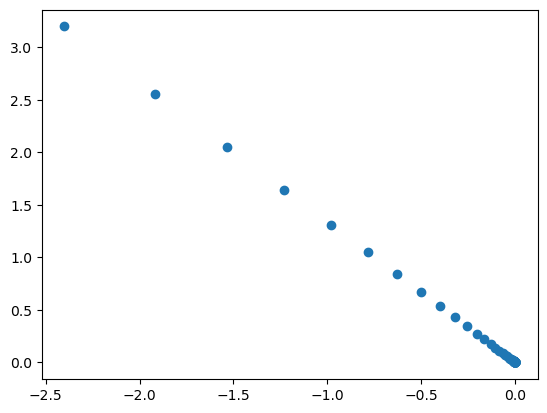

array([-6.11110793e-10,  8.14814391e-10])

In [100]:
# 문제: 경사법으로 f(x0, x1) = x0**2 + x1**2의 최솟값을 구하라

def function_2(x):
    return x[0]**2 + x[1]**2

init_x = np.array([-3.0, 4.0])
gradient_descent(function_2, init_x = init_x, lr = 0.1, step_num = 100)
# 결과값으로 거의 (0, 0)이 나옴, 실제 최솟값은 (0, 0)이므로 거의 정확한 결과를 얻었다고 볼 수 있음
# 학습률을 너무 높이거나 낮추면 큰값으로 발산해버리거나 거의 갱신되지 않은채 끝나버림

## 신경망에서의 기울기